In [1]:
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
import torch.nn as nn
import torchsummary
import torch
import torch.optim as optim

from dgzc.dataset import DGZCAutoEncoderDataset, DGZCClassifierDataset, DGZCInferenceDataset
from dgzc.autoencoder import Encoder, Decoder, AutoEncoderFaceImages
from dgzc.classifier import ClassificationBackbone, AutoEncoderClassifierAmalgamation

In [2]:
data_path = "/home/shivam/2021-22-2/ML4CE/Assignments/Assignment3/Driver-Gaze-Zone-Classification/data/gaze_dataset"
dataset_auto_enc = DGZCAutoEncoderDataset(data_path, size=(200, 200))
# dataset_classifier = DGZCClassifierDataset(data_path, size=(200, 200))
# dataset_inference = DGZCInferenceDataset(data_path, size=(200, 200))

In [4]:
dataloader = DataLoader(dataset_auto_enc, batch_size = 50, shuffle = True, num_workers=5)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
data_len = len(dataloader)
log_n = int(data_len//3)

In [7]:
model = AutoEncoderFaceImages()
model.to(device)

AutoEncoderFaceImages(
  (encoder): Encoder(
    (conv1): Conv2DNormActivation(
      (0): Conv2d(3, 5, kernel_size=(5, 5), stride=(2, 2))
      (1): SELU()
    )
    (conv2): Conv2DNormActivation(
      (0): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1), bias=False)
      (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
    )
    (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2DNormActivation(
      (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
      (1): SELU()
    )
    (conv4): Conv2DNormActivation(
      (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
      (1): SELU()
    )
    (conv5): Conv2DNormActivation(
      (0): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
    )
    (conv6): Conv2DNormActivation(
      (0): Conv2d(30, 40,

In [20]:
load_prev_state = True
if load_prev_state:
    model.encoder.load_state_dict(torch.load('./encoder_state'))
    model.decoder.load_state_dict(torch.load('./decoder_state'))

In [21]:
torchsummary.summary(model, (3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 98, 98]             380
              SELU-2            [-1, 5, 98, 98]               0
            Conv2d-3           [-1, 10, 94, 94]           1,250
       BatchNorm2d-4           [-1, 10, 94, 94]              20
              SELU-5           [-1, 10, 94, 94]               0
         MaxPool2d-6           [-1, 10, 47, 47]               0
            Conv2d-7           [-1, 20, 45, 45]           1,820
              SELU-8           [-1, 20, 45, 45]               0
            Conv2d-9           [-1, 20, 43, 43]           3,620
             SELU-10           [-1, 20, 43, 43]               0
           Conv2d-11           [-1, 30, 41, 41]           5,400
      BatchNorm2d-12           [-1, 30, 41, 41]              60
             SELU-13           [-1, 30, 41, 41]               0
           Conv2d-14           [-1, 40,

In [22]:
criterion =  nn.MSELoss() # Loss function
params_list = model.parameters() # model parameters
optimizer = optim.AdamW(params_list, lr = 0.0007, weight_decay=0.0001)

In [23]:
def compute_loss(dl, model, crt):
    total_loss = 0.
    cnt = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data, target in dl:
            data = data.to(device)
            
            # calculate outputs by running images through the network
            output = model(data)

            loss = crt(output, data)
            
            # print(predicted, labels)
            total_loss += loss.item()
            cnt += 1
    return total_loss/cnt

In [24]:
rll = []
total_loss = []

In [25]:
model.train()

AutoEncoderFaceImages(
  (encoder): Encoder(
    (conv1): Conv2DNormActivation(
      (0): Conv2d(3, 5, kernel_size=(5, 5), stride=(2, 2))
      (1): SELU()
    )
    (conv2): Conv2DNormActivation(
      (0): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1), bias=False)
      (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
    )
    (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2DNormActivation(
      (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
      (1): SELU()
    )
    (conv4): Conv2DNormActivation(
      (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
      (1): SELU()
    )
    (conv5): Conv2DNormActivation(
      (0): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
    )
    (conv6): Conv2DNormActivation(
      (0): Conv2d(30, 40,

In [26]:
for epoch in range(50):
    running_loss = 0.0
    for i, (data, target) in enumerate(dataloader):
        data = data.to(device) # Move data to target device

        # zero the parameter gradients
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i%log_n == log_n-1:
            rll += [epoch, i, running_loss]
            print(f'Epoch : {epoch}, Iteration : {i},Running loss : {running_loss/log_n}')
            running_loss = 0
    if epoch%10 == 0:
        total_loss += [compute_loss(dataloader, model, criterion)]
        print(f'Total loss : {total_loss[-1]}')

Epoch : 0, Iteration : 19,Running loss : 0.019264405081048607
Epoch : 0, Iteration : 39,Running loss : 0.015126614458858966
Epoch : 0, Iteration : 59,Running loss : 0.014265278819948435
Total loss : 0.014177555508423046
Epoch : 1, Iteration : 19,Running loss : 0.01402705954387784
Epoch : 1, Iteration : 39,Running loss : 0.014445425430312752
Epoch : 1, Iteration : 59,Running loss : 0.01367908315733075
Epoch : 2, Iteration : 19,Running loss : 0.014019480068236589
Epoch : 2, Iteration : 39,Running loss : 0.013836355414241552
Epoch : 2, Iteration : 59,Running loss : 0.013592519843950868
Epoch : 3, Iteration : 19,Running loss : 0.015170420100912452
Epoch : 3, Iteration : 39,Running loss : 0.014048166573047638
Epoch : 3, Iteration : 59,Running loss : 0.014241864392533898
Epoch : 4, Iteration : 19,Running loss : 0.015431289095431566
Epoch : 4, Iteration : 39,Running loss : 0.014222730044275522
Epoch : 4, Iteration : 59,Running loss : 0.013826136756688357
Epoch : 5, Iteration : 19,Running loss

KeyboardInterrupt: 

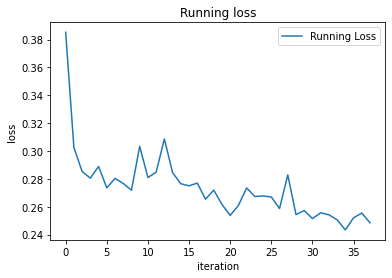

In [27]:
plt.plot(np.array(rll).reshape((-1, 3))[:, 2], label='Running Loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Running loss')
plt.legend()
plt.show()

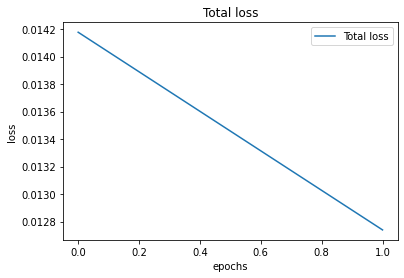

In [28]:
plt.plot(total_loss, label='Total loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Total loss')
plt.legend()
plt.show()

In [29]:
torch.save(model.encoder.state_dict(), './encoder_state')
torch.save(model.decoder.state_dict(), './decoder_state')

In [30]:
model.eval()

AutoEncoderFaceImages(
  (encoder): Encoder(
    (conv1): Conv2DNormActivation(
      (0): Conv2d(3, 5, kernel_size=(5, 5), stride=(2, 2))
      (1): SELU()
    )
    (conv2): Conv2DNormActivation(
      (0): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1), bias=False)
      (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
    )
    (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2DNormActivation(
      (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
      (1): SELU()
    )
    (conv4): Conv2DNormActivation(
      (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
      (1): SELU()
    )
    (conv5): Conv2DNormActivation(
      (0): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
    )
    (conv6): Conv2DNormActivation(
      (0): Conv2d(30, 40,

In [31]:
sample_input, target = iter(dataloader).next()

In [32]:
sample_input = sample_input.to(device)

In [33]:
sample_output = model(sample_input)

In [34]:
imgs = sample_output.detach().cpu().permute(0, 2, 3, 1).numpy()
src_imgs = sample_input.detach().cpu().permute(0, 2, 3, 1).numpy()

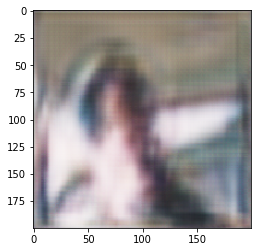

In [36]:
plt.imshow(imgs[10, ::])
plt.show()

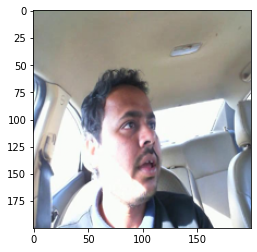

In [38]:
plt.imshow(src_imgs[10, ::])
plt.show()